In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from matplotlib import pyplot as plt

import string
import os

from sktime.classification.shapelet_based import MrSEQLClassifier
#https://github.com/sktime/sktime/blob/v0.8.1/sktime/classification/shapelet_based/mrseql/mrseql.pyx
from sktime.datasets._data_io import load_from_tsfile_to_dataframe

## Test on paper examples

### Obsvervations

- recoded the cpp sax_converter into Python
- the order of alphabet is inversed compared to article ("a" = low value and not high)
- in the article the examples are not normalized

### Constant parameters

In [2]:
alpha = 4
break_points = [-0.674489750196, 0.0, 0.674489750196]

### Only 1 windows

In [3]:
def segment2SAX(timeseries, cur_pos, l, w, paper_alphabet_order = False, normalize=True):
    # adaptation of this code https://github.com/sktime/sktime/blob/v0.8.1/sktime/classification/shapelet_based/mrseql/sax_converter.h
    # the following variable renaming is to better compare both implementation

    window_size = l
    word_length = w
    alphabet_size = alpha

    window_end = cur_pos + window_size

    mean_wd = np.mean(timeseries[cur_pos:window_end])
    var_wd = np.var(timeseries[cur_pos:window_end])

    subsection = np.zeros(window_size)
    for i in range(cur_pos, window_end):
        if normalize:
            normalized_value = timeseries[i]-mean_wd
            if var_wd>0:
                normalized_value = normalized_value / np.sqrt(var_wd)
        else:
            normalized_value = timeseries[i]
        subsection[i-cur_pos] = normalized_value
        
    paa_size = window_size / word_length
    sax_word = ""
    list_PPA = np.zeros(int(paa_size)*word_length)
    for i in range(word_length):
        bin = 0
        windowStartIdx = paa_size * i
        windowEndIdx = paa_size * (i + 1) - 1
        fullWindowStartIdx = int(np.ceil(windowStartIdx))
        fullWindowEndIdx = int(np.floor(windowEndIdx))
        startFraction = fullWindowStartIdx - windowStartIdx
        endFraction = windowEndIdx - fullWindowEndIdx
        aggValue = 0
        if (startFraction > 0):
            aggValue += subsection[fullWindowStartIdx - 1] * startFraction
        # 2nd condition is a safeguard against index-out-of-bounds because of
        # numerical imprecision
        if (endFraction > 0 and fullWindowEndIdx < window_size - 1) :
            aggValue += subsection[fullWindowEndIdx + 1] * endFraction
        for j in range(fullWindowStartIdx, fullWindowEndIdx+1):
            aggValue += subsection[j]
        PAA = aggValue / paa_size
        for k in range(int(paa_size)):
            list_PPA[int(paa_size)*i+k] = PAA
        for j in range(alphabet_size-1):
            if (PAA >= break_points[j]):
                bin += 1
        if paper_alphabet_order:
            sax_word += string.ascii_lowercase[alphabet_size - bin - 1]
        else:
            sax_word += string.ascii_lowercase[bin]
    return sax_word, list_PPA, subsection

In [4]:
timeseries = np.array([0.323, 0.742, 0.912, 1.021, -0.044, 0.124, -0.532, 0.001])

l = timeseries.shape[0]
w = 4

As in the article: babc (i.e. not normalized and 'a' for high value)
As it is used: cdba (i.e. normalized and 'a' for low value)


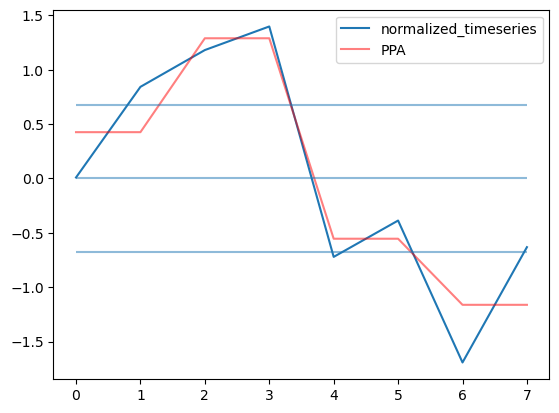

In [5]:
sax_word, list_PPA, subsection = segment2SAX(timeseries, 0, l, w, paper_alphabet_order=True, normalize=False)
print(f"As in the article: {sax_word} (i.e. not normalized and 'a' for high value)")

sax_word, list_PPA, subsection = segment2SAX(timeseries, 0, l, w)
print(f"As it is used: {sax_word} (i.e. normalized and 'a' for low value)")

plt.plot(subsection, label="normalized_timeseries")
plt.plot(list_PPA, alpha=0.5, color="r", label = "PPA")
plt.hlines(break_points, 0, l-1, alpha=0.5)
plt.legend()
plt.show()

### Sliding windows

In [6]:
def timeseries2SAX(timeseries, l, w, paper_alphabet_order=False, normalize=True):
    L = timeseries.shape[0]
    # PAA transform (and inverse transform) of the data
    list_word = []
    for cur_pos in range(L-l+1):
        sax_word, list_PPA, subsection = segment2SAX(timeseries, cur_pos, l, w, paper_alphabet_order, normalize)
        list_word.append(sax_word)
    return list_word

In [7]:
timeseries = np.array([0.323, 0.742, 0.912, 1.021, -0.044, 0.124, -0.532, 0.001, -0.343, -1.211])

l = 8
w = 4

In [8]:
list_word = timeseries2SAX(timeseries, l, w, paper_alphabet_order=True, normalize=False)
print(f"As in the article: {' '.join(list_word)} (i.e. not normalized and 'a' for high value)")

list_word = timeseries2SAX(timeseries, l, w)
print(f"As it is used: {' '.join(list_word)} (i.e. normalized and 'a' for low value)")

As in the article: babc abcc abcd (i.e. not normalized and 'a' for high value)
As it is used: cdba dcaa dcba (i.e. normalized and 'a' for low value)


## GunPoint example

### Load data and show example

In [9]:
DATA_PATH = os.path.join("./../data/Univariate_ts/")

In [10]:
dataset_name = "GunPoint"

class_dict = {"1": "Gun", "2": "Point"}

X_train, y_train = load_from_tsfile_to_dataframe(
    os.path.join(DATA_PATH, dataset_name, f"{dataset_name}_TRAIN.ts")
)
X_test, y_test = load_from_tsfile_to_dataframe(
    os.path.join(DATA_PATH, dataset_name, f"{dataset_name}_TEST.ts")
)

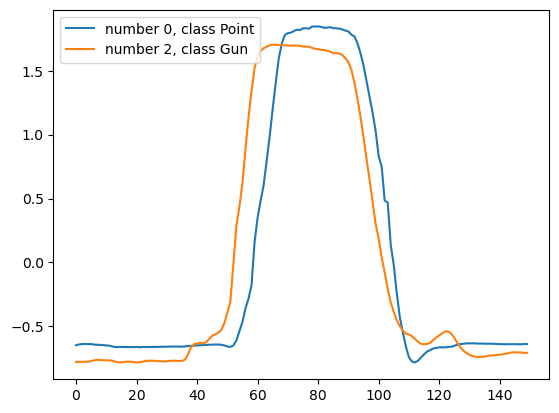

In [11]:
## An example of Time Series from this dataset

i, j = 0, 2
plt.plot(X_train["dim_0"].iloc[i], label=f"number {i}, class {class_dict[y_train[i]]}")
plt.plot(X_train["dim_0"].iloc[j], label=f"number {j}, class {class_dict[y_train[j]]}")

plt.legend()
plt.show()

### Set the config and train the classifier

In [12]:
L = X_train["dim_0"][0].shape[0]

w = 16

list_l = list(range(20, L, 11)) #PB IF W DOESN'T DIVIDE L
#list_l = list(range(w, L, w))

custom_config = []
for i in range(len(list_l)):
    custom_config.append({'method': 'sax', 'window': list_l[i], 'word': 16, 'alphabet': 4})

In [13]:
clf = MrSEQLClassifier(seql_mode="fs", symrep=('sax'), custom_config=custom_config)
clf.fit(X_train, y_train)
Y_predict = clf.predict(X_train)

In [14]:
coeffs = clf.ots_clf.coef_[0]
abs_coeffs = np.abs(coeffs)
sorted_sequences_idx = abs_coeffs.argsort()[::-1]

thresholds = [0]
cum_sum = 0
for sequence_l in clf.sequences:
    cum_sum += len(sequence_l)
    thresholds.append(cum_sum)
thresholds

[0, 70, 137, 202, 259, 317, 386, 458, 494, 532, 569, 616, 666]

In [15]:
def find_l(thresholds, ind):
    for num_l in range(len(list_l)):        
        if thresholds[num_l] <= ind < thresholds[num_l+1]:
            return num_l, ind-thresholds[num_l]

In [16]:
important_coeffs = []
important_sequences = []
important_l = []



for ind in sorted_sequences_idx[:10]:
    coeff = coeffs[ind]
    num_l, num_seq = find_l(thresholds, ind)
    SOI = clf.sequences[num_l][num_seq].decode("utf-8") #sequence of interest
    lOI = list_l[num_l] #l of interest

    important_coeffs.append(coeff)
    important_sequences.append(SOI)
    important_l.append(lOI)

In [17]:
for i in np.array(important_coeffs).argsort()[::-1]:
    print(important_l[i], str("{:.3f}".format(important_coeffs[i])).rjust(6), important_sequences[i])

42  0.033 cbaab
53  0.031 ddddb
42  0.030 da
42 -0.030 dddccbbbbbbb
42 -0.031 bbbbbbbba
42 -0.031 aaaaaaabbcdddddd
53 -0.031 bbbcddddd
53 -0.032 bbbbbbbaaa
20 -0.033 bbbbaaaaaa
53 -0.034 bbbbbbaaa


### Do the plots

Inspired from here `https://github.com/lnthach/Mr-SEQL/blob/master/src/python/visual_timeseries.py`

In [18]:
def compute_log_color(x):
	return (1.0/(1.0 + np.exp(-100*x)) - 0.5)*2

def compute_linewidth(x):
	return 1.0 + 4.0*x

def plot_thickness(ts,metats):
	maxw = max(metats)
	# normalize the scores
	if maxw > 0:
		metats = metats / maxw
	lwa = np.array([compute_linewidth(x) for x in metats])
	# maxc = max(metats)
	# minc = min(metats)
	colormap = np.array([compute_log_color(x) for x in metats])

	for i in range(0,len(ts)-1):
		lw = (lwa[i] + lwa[i+1])/2
		color = (colormap[i]+colormap[i+1])/2
		plt.plot([i,i+1],ts[i:(i+2)],linewidth = lw,c=[color,0,max(0,0.8 - color)])

In [19]:
def plot_ROI(num_data):
    timeseries = X_train["dim_0"][num_data].to_numpy()
    y = y_train[num_data]
    y_predict = Y_predict[num_data]
    print(f"True label: {class_dict[y]}, predict label: {class_dict[y_predict]}")
    w = 16

    SAX_repr = dict()
    for l in list_l:
        list_word = timeseries2SAX(timeseries, l, w)
        SAX_repr[l] = list_word

    list_begin_ROI = []
    list_end_ROI = []
    list_coeff = []

    for ind in sorted_sequences_idx:
        coeff = coeffs[ind]
        num_l, num_seq = find_l(thresholds, ind)
        SOI = clf.sequences[num_l][num_seq].decode("utf-8") #sequence of interest
        lOI = list_l[num_l] #l of interest
        for pos, word in enumerate(SAX_repr[lOI]):
            if SOI in word:
                list_begin_ROI.append(pos)
                list_end_ROI.append(pos + len(SOI))
                list_coeff.append(coeff)

    plt.plot(timeseries)
    list_width = np.zeros_like(timeseries)
    for begin_ROI, end_ROI, coeff in zip(list_begin_ROI, list_end_ROI, list_coeff):
        list_width[begin_ROI:end_ROI] += coeff
    if y == "1" :
        list_width = - list_width

    plot_thickness(timeseries, np.maximum(list_width, 0))
    plt.show()

True label: Point, predict label: Point


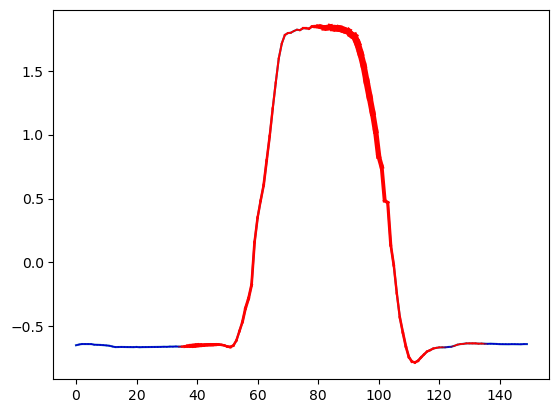

True label: Point, predict label: Point


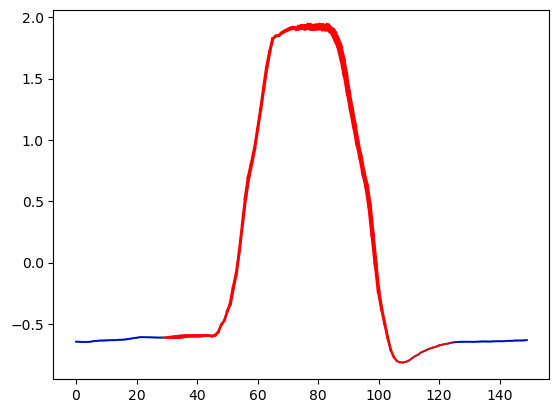

True label: Gun, predict label: Gun


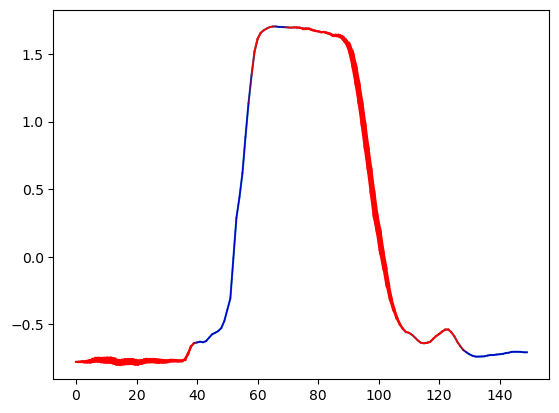

True label: Gun, predict label: Gun


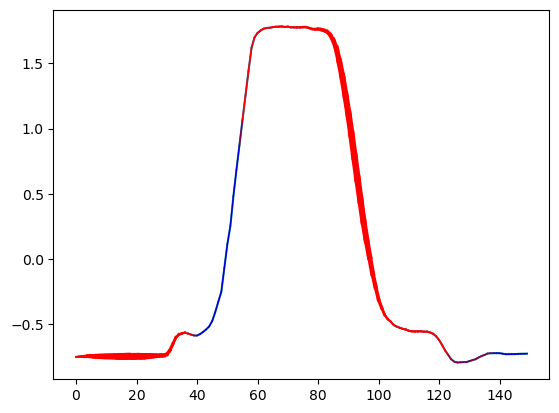

True label: Point, predict label: Point


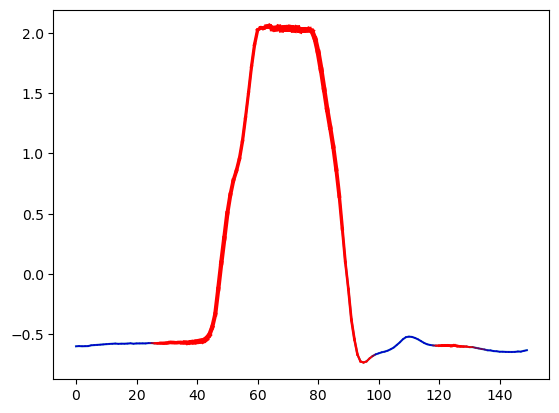

True label: Point, predict label: Point


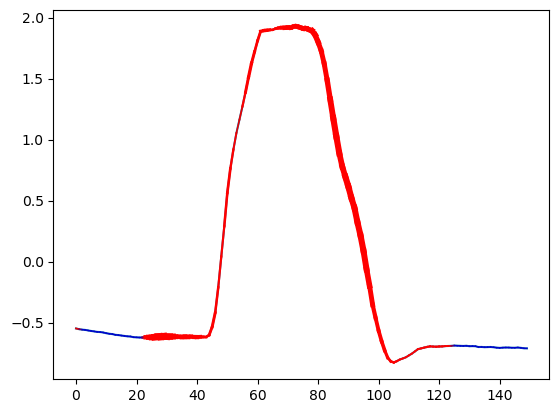

True label: Point, predict label: Point


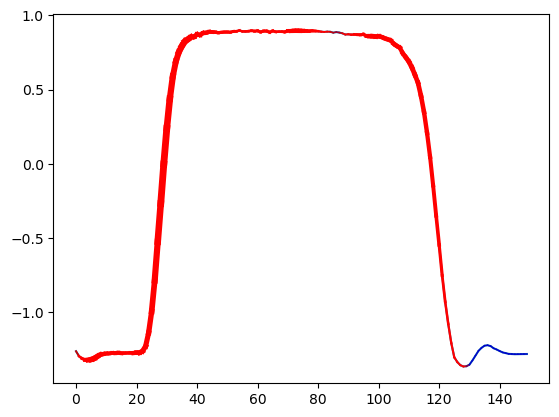

True label: Point, predict label: Point


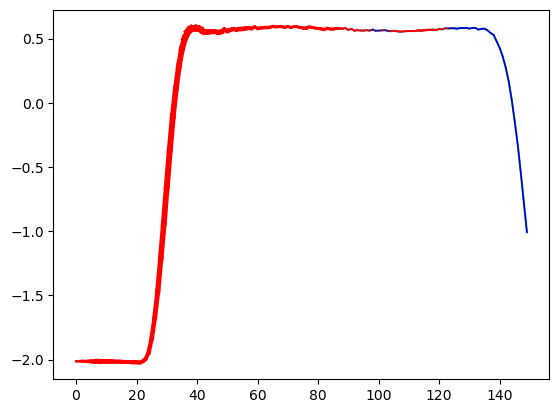

True label: Point, predict label: Point


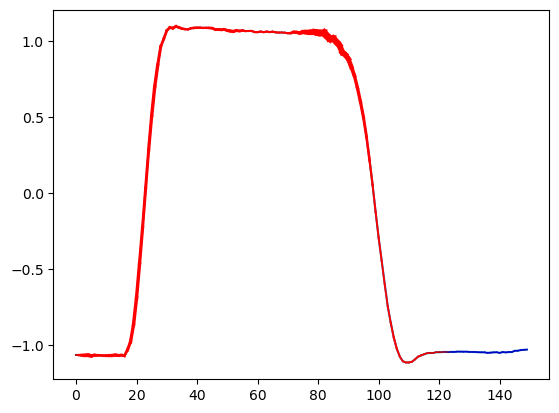

True label: Gun, predict label: Gun


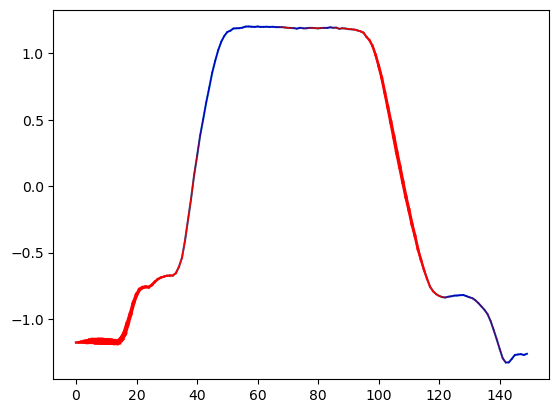

In [20]:
for num_data in range(10):
    plot_ROI(num_data=num_data)